In [490]:
import math
import numpy
from matplotlib import pyplot

In [491]:
#Q = 2000/3    #strength of the source-sheet,stb/d
Dx=9.8425
Dy=9.8425
h=26.25        #thickness of local gridblock,ft
phi=0.2        #porosity 
kx=200         #pemerability in x direction,md
ky=200        #pemerability in y direction,md
kr=kx/ky       #pemerability ratio
miu=1          #viscosity,cp

Nw=1                    #Number of well
Nimg=40                 #Number of image well
rab=0.00003       #distance betwwen node pairs
Qwell_1=2000            #Flow rate of well 1

In [492]:
class Panel:
    """Contains information related to a panel."""
    def __init__(self, xa, ya, xb, yb):
        """Creates a panel.
        
        Arguments
        ---------
        xa, ya -- Cartesian coordinates of the first end-point.
        xb, yb -- Cartesian coordinates of the second end-point.
        x_a,y_a -- node pair A, inner point 
        y_b,
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2            # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        #unit vector (x2-x1)/length  (y2-y1)/length
        #normal unit vector (y1-y2)/length   (x2-x1)/length
        #point with a given distance along a line: x?=x_Start+unit_vector_x*distance  y?=y_Start+unit_vector_y*distance
        self.x_a=self.xc-rab/2*(ya-yb)/self.length
        self.y_a=self.yc-rab/2*(xb-xa)/self.length
        self.x_b=self.xc+rab/2*(ya-yb)/self.length
        self.y_b=self.yc+rab/2*(xb-xa)/self.length
        
        # orientation of the panel (angle between x-axis and panel)
        self.sinalpha=(yb-ya)/self.length
        self.cosalpha=(xb-xa)/self.length
        
        self.Q = 0.                                # source strength
        self.U = 0.                                # velocity component
        self.V = 0.                                # velocity component
        self.P = 0.                                # pressure coefficient

class Well:
    """Contains information related to a panel."""
    def __init__(self, xw, yw,rw,Q):
        """Creates a panel.
        
        Arguments
        ---------
        xw, yw -- Cartesian coordinates of well source.
        Q      -- Flow rate of well source.
        rw     -- radius of well source.
        """
        self.xw, self.yw = xw, yw
        
        self.Q = Q                               # source strength
        self.rw = rw                             # well radius


In [493]:
def cosspace(st,ed,N):
    N=N+1
    AngleInc=numpy.pi/(N-1)
    CurAngle = AngleInc
    space=numpy.linspace(0,1,N)
    space[0]=st
    for i in range(N-1):
        space[i+1] = 0.5*numpy.abs(ed-st)*(1 - math.cos(CurAngle));
        CurAngle += AngleInc
    if ed<st:
        space[0]=ed
        space=space[::-1]
    return space

In [494]:
#Create the array
N=80
Nbd=20


x_ends = numpy.linspace(0, 1, N)    # computes a 1D-array for x
x_ends_img= numpy.linspace(0, 1, N)
y_ends = numpy.linspace(0, 1, N)    # computes a 1D-array for y
y_ends_img= numpy.linspace(0, 1, N)


interval=cosspace(0,Dx,Nbd)
rinterval=cosspace(Dx,0,Nbd)
#interval=numpy.linspace(0,Dx,Nbd+1)
#rinterval=numpy.linspace(Dx,0,Nbd+1)

#Define the rectangle boundary


for i in range(Nbd):
    x_ends[i]=0
    y_ends[i]=interval[i]

for i in range(Nbd):
    x_ends[i+Nbd]=interval[i]
    y_ends[i+Nbd]=Dy
    
for i in range(Nbd):
    x_ends[i+Nbd*2]=Dx
    y_ends[i+Nbd*2]=rinterval[i]
    
for i in range(Nbd):
    x_ends[i+Nbd*3]=rinterval[i]
    y_ends[i+Nbd*3]=0
    
x_ends,y_ends=numpy.append(x_ends, x_ends[0]), numpy.append(y_ends, y_ends[0])


#Define the panel/node pairs
panels = numpy.empty(N, dtype=object)

for i in range(N):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])

    
#Define boundary conditions
for i in range(Nbd):
    panels[i].Q=0.
    panels[i+Nbd].Q=1000.
    panels[i+Nbd*2].Q=1000.
    panels[i+Nbd*3].Q=0.
    
# Generalize the image well position/Define the image panel around the computation domain
R=Dx
x_ends = Dx/2+R*numpy.cos(numpy.linspace(0, 2*math.pi, Nimg+1))
y_ends = Dy/2+R*numpy.sin(numpy.linspace(0, 2*math.pi, Nimg+1))

panels_img = numpy.empty(Nimg, dtype=object)
for i in range(Nimg):
    panels_img[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])

    
#Define the well
wells = numpy.empty(Nw, dtype=object)

wells[0]=Well(Dx/2,Dy/2,0.025,Qwell_1)




In [495]:
#for i in range(N):
    #print("%s Panel Coordinate (%s,%s) sina,cosa (%s,%s) Q:%s" % (i+1,panels[i].xc,panels[i].yc,panels[i].sinalpha,panels[i].cosalpha,panels[i].Q))
   # print("%s NodePair Coordinate A(%s,%s) B(%s,%s) Q:%s" % (i+1,panels[i].x_a,panels[i].y_a,panels[i].x_b,panels[i].y_b,panels[i].Q))
    #print("Well Location (%s,%s) radius: %s Flow rate:%s  " % (wells[0].xw,wells[0].yw,wells[0].rw,wells[0].Q))

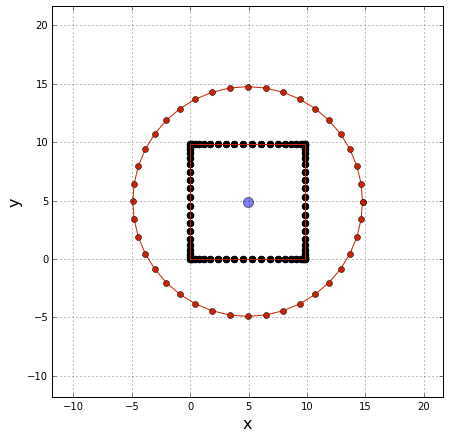

In [496]:
#Plot the panel
%matplotlib inline

val_x, val_y = 1.2, 1.2
x_min, x_max = min(panel.xa for panel in panels), max(panel.xa for panel in panels)
y_min, y_max = min(panel.ya for panel in panels), max(panel.ya for panel in panels)
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = y_min-val_y*(y_max-y_min), y_max+val_y*(y_max-y_min)

size = 7
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)

pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa), 
         numpy.append([panel.ya for panel in panels], panels[0].ya), 
         linestyle='-', linewidth=1, marker='o', markersize=0, color='#CD2305');

pyplot.plot(numpy.append([panel.xa for panel in panels_img], panels_img[0].xa), 
         numpy.append([panel.ya for panel in panels_img], panels_img[0].ya), 
         linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305');


#pyplot.scatter([w.xw for w in Image_wells], [w.yw for w in Image_wells], color='#CD2305', s=40)
pyplot.scatter([p.x_a for p in panels], [p.y_a for p in panels], color='k', s=40)
pyplot.scatter([p.x_b for p in panels], [p.y_b for p in panels], color='k', s=40)


pyplot.scatter(wells[0].xw,wells[0].yw,s=100,alpha=0.5)

In [497]:
#Panel infuence factor
def InflueceP(x, y, panel):
    """Evaluates the contribution of a panel at one point.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the point.
    panel -- panel which contribution is evaluated.
    
    Returns
    -------
    Integral over the panel of the influence at one point.
    """
#Transfer global coordinate point(x,y) to local coordinate
    x=x-panel.xa
    y=y-panel.ya
    L1=panel.length
    
#Calculate the pressure and velocity influence factor
    a=panel.cosalpha**2+kr*panel.sinalpha**2
    b=x*panel.cosalpha+kr*panel.sinalpha*y
    c=y*panel.cosalpha-x*panel.sinalpha
    dp=-70.6*miu/h/math.sqrt(kx*ky)
    Cp = -1/a*(
                             (
                              b*math.log(x**2-2*b*L1+a*L1**2+kr*y**2)
                             -L1*a*math.log((x-L1*panel.cosalpha)**2+kr*(y-L1*panel.sinalpha)**2)
                             +2*math.sqrt(kr)*c*math.atan((b-a*L1)/math.sqrt(kr)/c)
                             )
                             -
                             (
                               b*math.log(x**2+kr*y**2)
                               +2*math.sqrt(kr)*c*math.atan((b)/math.sqrt(kr)/c)
                             )         
                )
    #debug
    #print("a: %s b:%s c:%s  " % (a,b,c))
    #angle=math.atan((b-a*L1)/math.sqrt(kr)/c)*180/numpy.pi
    #print("Magic angle:%s"% angle)
    return Cp

def InflueceU(x, y, panel):
    """Evaluates the contribution of a panel at one point.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the point.
    panel -- panel which contribution is evaluated.
    
    Returns
    -------
    Integral over the panel of the influence at one point.
    """
#Transfer global coordinate point(x,y) to local coordinate
    x=x-panel.xa
    y=y-panel.ya
    L1=panel.length

#Calculate the pressure and velocity influence factor
    a=panel.cosalpha**2+kr*panel.sinalpha**2
    b=x*panel.cosalpha+kr*panel.sinalpha*y
    c=y*panel.cosalpha-x*panel.sinalpha
    dv=-0.4468/h/phi*math.sqrt(kx/ky)
    Cu = dv/a*(
                             ( 
                            panel.cosalpha*math.log(x**2-2*b*L1+a*L1**2+kr*y**2)+ 2*math.sqrt(kr)*panel.sinalpha*math.atan((a*L1-b)/math.sqrt(kr)/c) 
                             )
                            -
                             (
                            panel.cosalpha*math.log(x**2+kr*y**2)+2*math.sqrt(kr)*panel.sinalpha*math.atan((-b)/math.sqrt(kr)/c)
                             )    
                     )  
    #print("a: %s b:%s c:%s  " % (a,b,c))
    #angle=math.atan((b-a*L1)/math.sqrt(kr)/c)*180/numpy.pi
    #print("Magic angle:%s"% angle)
    return Cu

def InflueceV(x, y, panel):
    """Evaluates the contribution of a panel at one point.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the point.
    panel -- panel which contribution is evaluated.
    
    Returns
    -------
    Integral over the panel of the influence at one point.
    """
#Transfer global coordinate point(x,y) to local coordinate
    x=x-panel.xa
    y=y-panel.ya
    L1=panel.length

#Calculate the pressure and velocity influence factor
    a=panel.cosalpha**2+kr*panel.sinalpha**2
    b=x*panel.cosalpha+kr*panel.sinalpha*y
    c=y*panel.cosalpha-x*panel.sinalpha
    dv=-0.4468/h/phi*math.sqrt(kx/ky)
    Cv = dv/a*(
                             ( 
                            panel.sinalpha*math.log(x**2-2*b*L1+a*L1**2+kr*y**2)+ 2*math.sqrt(1/kr)*panel.cosalpha*math.atan((b-a*L1)/math.sqrt(kr)/c) 
                             )
                            -
                             (
                            panel.sinalpha*math.log(x**2+kr*y**2)+2*math.sqrt(1/kr)*panel.cosalpha*math.atan((b)/math.sqrt(kr)/c)
                             )    
                     )    
    #print("a: %s b:%s c:%s  " % (a,b,c))
    #angle=math.atan((b-a*L1)/math.sqrt(kr)/c)*180/numpy.pi
    #print("Magic angle:%s"% angle)

    return Cv

In [498]:
#Well influence factor
def InflueceP_W(x, y, well):
    """Evaluates the contribution of a panel at one point.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the point.
    panel -- panel which contribution is evaluated.
    
    Returns
    -------
    Integral over the panel of the influence at one point.
    """
    dp=-70.6*miu/h/math.sqrt(kx*ky)
    #Cp=dp*math.log((x-well.xw)**2+kr*(y-well.yw)**2)
    Cp=math.log((x-well.xw)**2+kr*(y-well.yw)**2)
    return Cp

def InflueceU_W(x, y, well):
    """Evaluates the contribution of a panel at one point.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the point.
    panel -- panel which contribution is evaluated.
    
    Returns
    -------
    Integral over the panel of the influence at one point.
    """
    dv=0.8936/h/phi*math.sqrt(kx/ky)
    Cu=dv*(x-well.xw)/((x-well.xw)**2+kr*(y-well.yw)**2)
    return Cu

def InflueceV_W(x, y, well):
    """Evaluates the contribution of a panel at one point.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the point.
    panel -- panel which contribution is evaluated.
    
    Returns
    -------
    Integral over the panel of the influence at one point.
    """
    dv=0.8936/h/phi*math.sqrt(kx/ky)
    Cv=dv*(y-well.yw)/((x-well.xw)**2+kr*(y-well.yw)**2)
    return Cv

In [499]:
def build_matrix(panels):
    """Builds the source matrix.
    
    Arguments
    ---------
    panels -- array of panels.
    
    Returns
    -------
    A -- NxN matrix (N is the number of panels).
    """
    N = len(panels)
    A = numpy.empty((N, Nimg), dtype=float)
    #numpy.fill_diagonal(A, 0.5)
    Coeff=-70.6*miu/h/math.sqrt(kx*ky)
    
    for i, p_i in enumerate(panels): #target nodes
        for j, p_j in enumerate(panels_img): #BE source
                #if i>=0 and i<Nbd or i>=3*Nbd and i<4*Nbd:     
                    A[i,j] = InflueceP(p_i.x_a,p_i.y_a,p_j)-InflueceP(p_i.x_b,p_i.y_b,p_j)
                    #A[i,j] /= Coeff
                    #A[i,j] = InflueceP(p_i.xc, p_i.yc, p_j)
                #if i>=Nbd and i<2*Nbd or i>=2*Nbd and i<3*Nbd:     
                    #A[i,j] = -p_j.sinalpha*InflueceU(p_i.xc, p_i.yc, p_j)+p_j.cosalpha*InflueceV(p_i.xc, p_i.yc, p_j)
                    #A[i,j] = InflueceP(p_i.xc, p_i.yc, p_j)
    return A

def build_rhs(panels):
    """Builds the RHS of the linear system.
    
    Arguments
    ---------
    panels -- array of panels.
    
    Returns
    -------
    b -- 1D array ((N+1)x1, N is the number of panels).
    """

    b = numpy.empty(len(panels), dtype=float)
    
    for i, p_i in enumerate(panels):
        #b[i]=Qwell_1*( InflueceP_W(p_i.x_b,p_i.y_b,wells[0])-InflueceP_W(p_i.x_a,p_i.y_a,wells[0]) )+887.1857*p_i.Q*miu*rab/Dx/h/kx
        #b[i] /= Coeff
        b[i]=Qwell_1*( InflueceP_W(p_i.x_b,p_i.y_b,wells[0])-InflueceP_W(p_i.x_a,p_i.y_a,wells[0]) )-4*numpy.pi*p_i.Q*rab*math.sqrt(kx*ky)/Dx/kx
        #b[i]=887.2*p_i.Q*miu*rab/Dx/h
    return b

In [500]:
A = build_matrix(panels)                    # computes the singularity matrix
b = build_rhs(panels)                       # computes the freestream RHS

In [501]:
4*numpy.pi*1000*rab*math.sqrt(kx*ky)/Dx/kx

0.03830237423731524

In [502]:
70.6*miu/h/math.sqrt(kx*ky)

0.013447619047619047

In [503]:
b

array([ 0.01226731,  0.01257115,  0.0131927 ,  0.01415603,  0.0154853 ,
        0.01718171,  0.01918004,  0.02128598,  0.02313123,  0.02423578,
        0.02423578,  0.02313123,  0.02128598,  0.01918004,  0.01718171,
        0.0154853 ,  0.01415603,  0.0131927 ,  0.01257115,  0.01226731,
       -0.02603507, -0.02573122, -0.02510968, -0.02414634, -0.02281707,
       -0.02112066, -0.01912233, -0.0170164 , -0.01517114, -0.0140666 ,
       -0.0140666 , -0.01517114, -0.0170164 , -0.01912233, -0.02112066,
       -0.02281707, -0.02414634, -0.02510968, -0.02573122, -0.02603507,
       -0.02603507, -0.02573122, -0.02510968, -0.02414634, -0.02281707,
       -0.02112066, -0.01912233, -0.0170164 , -0.01517114, -0.0140666 ,
       -0.0140666 , -0.01517114, -0.0170164 , -0.01912233, -0.02112066,
       -0.02281707, -0.02414634, -0.02510968, -0.02573122, -0.02603507,
        0.01226731,  0.01257115,  0.0131927 ,  0.01415603,  0.0154853 ,
        0.01718171,  0.01918004,  0.02128598,  0.02313123,  0.02

In [504]:
A

array([[ -5.48620784e-06,  -5.13742042e-06,  -4.79108551e-06, ...,
         -6.57866625e-06,  -6.20378275e-06,  -5.84062554e-06],
       [ -5.51609588e-06,  -5.17136312e-06,  -4.82794292e-06, ...,
         -6.58718696e-06,  -6.22128918e-06,  -5.86512622e-06],
       [ -5.57416234e-06,  -5.23800554e-06,  -4.90086485e-06, ...,
         -6.60122267e-06,  -6.25367950e-06,  -5.91195013e-06],
       ..., 
       [ -2.21831080e-06,  -2.66860653e-06,  -3.08672571e-06, ...,
         -5.74004808e-07,  -1.18386560e-06,  -1.72711371e-06],
       [ -2.15602113e-06,  -2.59854404e-06,  -3.01129494e-06, ...,
         -5.54691184e-07,  -1.14622139e-06,  -1.67542801e-06],
       [ -2.12543369e-06,  -2.56403619e-06,  -2.97402358e-06, ...,
         -5.45282489e-07,  -1.12783782e-06,  -1.65011957e-06]])

In [505]:
# solves the linear system
Q = numpy.linalg.lstsq(A, b)

for i in range(Nimg):
    panels_img[i].Q =Q[0][i]
    

In [506]:
Q[0]

array([ 368113.95693063,  366975.33220918,  367382.42691494,
        367257.09359321,  367354.26031266,  367354.14805368,
        367257.25979982,  367382.14919629,  366975.76272258,
        368113.38460663,  368129.86014543,  367022.70159778,
        367460.32616438,  367363.12016918,  367486.34987881,
        367508.5620862 ,  367430.60788185,  367569.78998256,
        367173.45610797,  368315.83657617,  368332.53342319,
        367220.25182775,  367648.02526091,  367536.45903223,
        367640.74999845,  367640.68406678,  367536.56667225,
        367647.82902429,  367220.58020678,  368332.06454985,
        368316.38766266,  367172.92836581,  367570.21606541,
        367430.28818696,  367508.82159279,  367486.08643129,
        367363.45446545,  367459.86753422,  367023.28608467,
        368129.22523935])

In [507]:
#for i in range(Nimg):
    #print("%s Image well flow rate:%s" %(i+1,Image_wells[i].Q))

In [508]:
#Visulize the pressure and velocity field

#Define meshgrid



Nx, Ny = 50, 50                  # number of points in the x and y directions
val_x, val_y = 0, 0
x_min, x_max = min(panel.xa for panel in panels), max(panel.xa for panel in panels)
y_min, y_max = min(panel.ya for panel in panels), max(panel.ya for panel in panels)
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = y_min-val_y*(y_max-y_min), y_max+val_y*(y_max-y_min)
x = numpy.linspace(x_start, x_end, Nx)    # computes a 1D-array for x
y = numpy.linspace(y_start, y_end, Ny)    # computes a 1D-array for y
X, Y = numpy.meshgrid(x, y)               # generates a mesh grid

#Calculate the velocity and pressure field
p = numpy.empty((Nx, Ny), dtype=float)
u = numpy.empty((Nx, Ny), dtype=float)
v = numpy.empty((Nx, Ny), dtype=float)

Coeff=-70.6*miu/h/math.sqrt(kx*ky)



for i in range(Nx):
    for j in range(Ny):
        p[i,j] =sum([w.Q*Coeff*InflueceP(X[i,j], Y[i,j], w) for w in panels_img])+Qwell_1*Coeff*InflueceP_W(X[i,j], Y[i,j], wells[0])-160
        u[i,j] =sum([w.Q*InflueceU(X[i,j], Y[i,j], w) for w in panels_img])+Qwell_1*InflueceU_W(X[i,j], Y[i,j], wells[0])
        v[i,j] =sum([w.Q*InflueceV(X[i,j], Y[i,j], w) for w in panels_img])+Qwell_1*InflueceV_W(X[i,j], Y[i,j], wells[0])

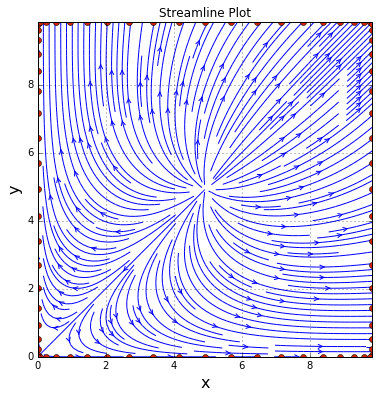

In [509]:
# plots the streamlines
%matplotlib inline

size = 6
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.title('Streamline Plot')
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)


pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa), 
         numpy.append([panel.ya for panel in panels], panels[0].ya), 
         linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305');
stream =pyplot.streamplot(X, Y, u, v,density=2, linewidth=1, arrowsize=1, arrowstyle='->') #streamline
#cbar=pyplot.colorbar(orientation='vertical')

#equipotential=pyplot.contourf(X, Y, p1, extend='both')

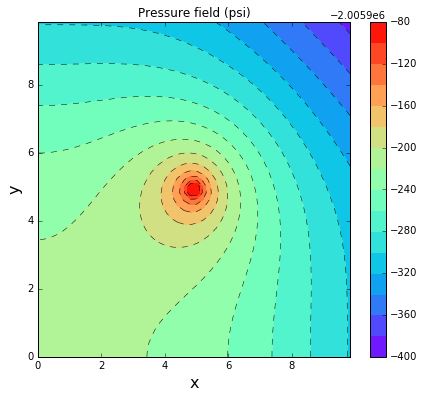

In [510]:
size = 7
pyplot.figure(figsize=(size, size-1))
pyplot.title('Pressure field (psi)')
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)

pyplot.contour(X, Y, p, 15,linewidths=0.5, colors='k')
pyplot.contourf(X, Y, p, 15,cmap='rainbow',)
pyplot.colorbar()  # draw colorbar

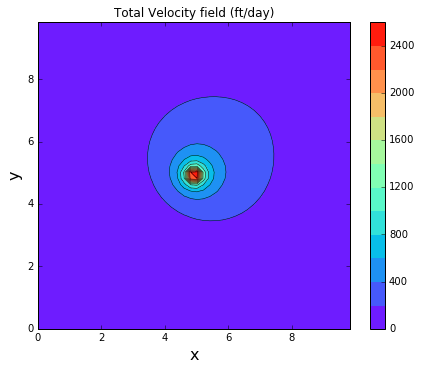

In [511]:
size = 7
pyplot.figure(figsize=(size, size-1.5))
pyplot.title('Total Velocity field (ft/day)')
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)

Vtotal= numpy.sqrt(u**2+v**2)
#Vtotal= numpy.abs(v)
pyplot.contour(X, Y, Vtotal, 15, linewidths=0.5, colors='k')
pyplot.contourf(X, Y, Vtotal, 15, cmap='rainbow')
                  #vmax=110, vmin=0)
pyplot.colorbar()  # draw colorbar

array([ 108.65833288,  108.65607892,  108.65757825,  108.65890791,
        108.65858304,  108.65711671,  108.65562429,  108.65490779,
        108.65519665,  108.65626637,  108.65766298,  108.6588998 ,
        108.65959481,  108.65955262,  108.65879533,  108.65754203,
        108.65614227,  108.6549795 ,  108.65436921,  108.65447781,
        108.65528186,  108.65657669,  108.65803067,  108.65927116,
        108.65998012,  108.65997567,  108.65925861,  108.65801236,
        108.65655601,  108.65526272,  108.65446388,  108.65436332,
        108.65498307,  108.65615509,  108.65756226,  108.65881985,
        108.6595776 ,  108.6596164 ,  108.65891488,  108.65766969,
        108.6562644 ,  108.65518717,  108.65489298,  108.65560677,
        108.65709882,  108.65856636,  108.65889295,  108.6575648 ,
        108.65606757,  108.65832956])

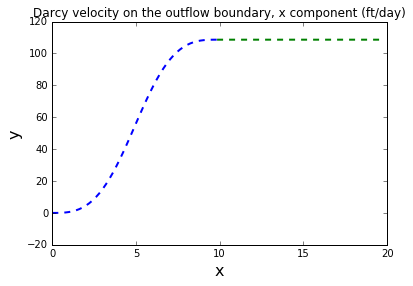

In [512]:
pyplot.title('Darcy velocity on the outflow boundary, x component (ft/day)')
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)

pyplot.plot(y, u[49,:], '--', linewidth=2)
pyplot.plot(9.8425+y, u[:,49], '--', linewidth=2)
u[:,49]

array([ 108.65829189,  108.65605024,  108.65756994,  108.65891554,
        108.65859741,  108.65712906,  108.65562905,  108.65490339,
        108.65518495,  108.65625135,  108.65764921,  108.65889113,
        108.65959348,  108.65955892,  108.65880774,  108.65755776,
        108.65615798,  108.65499207,  108.65437634,  108.65447841,
        108.65527615,  108.65656601,  108.65801712,  108.65925707,
        108.65996756,  108.659966  ,  108.65925229,  108.65800888,
        108.65655409,  108.65526065,  108.65445997,  108.65435631,
        108.65497251,  108.65614146,  108.65754695,  108.65880484,
        108.65956506,  108.65960812,  108.65891177,  108.65767144,
        108.65626938,  108.65519265,  108.65489575,  108.65560387,
        108.65708848,  108.65854862,  108.65886992,  108.65753997,
        108.6560442 ,  108.65830794])

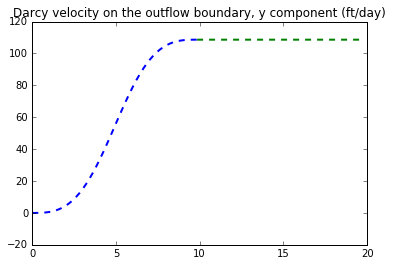

In [513]:
pyplot.title('Darcy velocity on the outflow boundary, y component (ft/day)')

pyplot.plot(y, v[:,49], '--', linewidth=2)
pyplot.plot(9.8425+y, v[49,:], '--', linewidth=2)
v[49,:]